In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, inspect

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
inspector = inspect(engine)
print(inspector.get_table_names())

['measurement', 'station']


In [5]:
columns = inspector.get_columns("measurement")
for c in columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [6]:
columns = inspector.get_columns("station")
for c in columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
for mappedclass in Base.classes:
    print (mappedclass)

<class 'sqlalchemy.ext.automap.measurement'>
<class 'sqlalchemy.ext.automap.station'>


In [9]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
query1 = """
        SELECT
            *
        FROM
            measurement
        """

conn = engine.connect()
df = pd.read_sql(query1, con=conn)
conn.close()

df.tail()

,id,station,date,prcp,tobs
19545,19546,USC00516128,2017-08-19,0.09,71.0
19546,19547,USC00516128,2017-08-20,NaN,78.0
19547,19548,USC00516128,2017-08-21,0.56,76.0
19548,19549,USC00516128,2017-08-22,0.50,76.0
19549,19550,USC00516128,2017-08-23,0.45,76.0


# Exploratory Climate Analysis

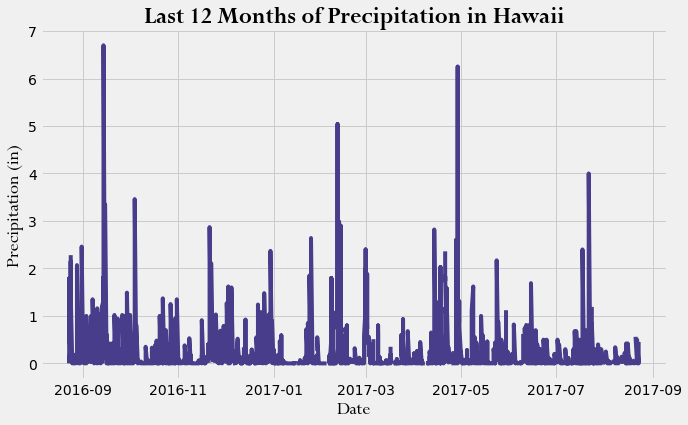

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
query2 = """
        SELECT
            date,
            prcp
        FROM
            measurement 
        WHERE
            date >= (
                        SELECT
                           date(MAX(date), '-365 day')
                        FROM
                            measurement
                    )
        ORDER BY
            date
        """
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date

conn = engine.connect()
df = pd.read_sql(query2, con=conn)
conn.close()

df["date"] = pd.to_datetime(df["date"])
df.head()

# Use Pandas Plotting with Matplotlib to plot the data

plt.figure(figsize=(10,6))
plt.plot(df.date, df.prcp, color="darkslateblue")
plt.title("Last 12 Months of Precipitation in Hawaii", fontweight="bold", fontsize=24, fontname="Perpetua")
plt.ylabel("Precipitation (in)", fontsize=20, fontname="Perpetua")
plt.xlabel("Date", fontsize=20, fontname="Perpetua")

plt.show()


In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
query3 = """
        SELECT
            count(*) as station_count
        FROM
            station
        """
conn = engine.connect()
df = pd.read_sql(query3, con=conn)
conn.close()

df

,station_count
0,9


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
query4 = """
        SELECT
        s.station,
        count(*) as tot_obs
        FROM
            station s
        JOIN measurement m on s.station = m.station
        GROUP BY s.station
        ORDER BY
            count(*) desc
        """
conn = engine.connect()
df = pd.read_sql(query4, con=conn)
conn.close()

df

,station,tot_obs
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
query5 = """
        SELECT
            m.date,
            m.prcp,
            m.tobs,
            s.station,
            s.name
        FROM
            measurement m
            join station s on m.station = s.station
        ORDER BY
            date
        """
conn = engine.connect()
df = pd.read_sql(query5, con=conn)
conn.close()

temp = df["tobs"]

print(temp.max())
print(temp.min())
print(temp.mean())

87.0
53.0
73.09795396419437


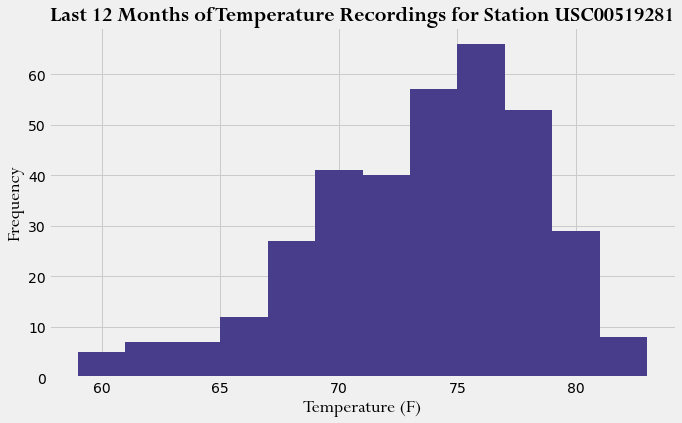

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query6 = """
        SELECT
            m.date,
            m.tobs,
            s.station,
            s.name
        FROM
            measurement m
            join station s on m.station = s.station
        WHERE
            s.station = "USC00519281" and
            date >= (
                        SELECT
                           date(MAX(date), '-365 day')
                        FROM
                            measurement
                    )
        ORDER BY
            date
        """
conn = engine.connect()
df_sub = pd.read_sql(query6, con=conn)
conn.close()

plt.figure(figsize=(10,6))
plt.hist(df_sub.tobs, bins=12, color="darkslateblue")
plt.title("Last 12 Months of Temperature Recordings for Station USC00519281", fontweight="bold", fontsize=22, fontname="perpetua")
plt.ylabel("Frequency", fontsize=20, fontname="perpetua")
plt.xlabel("Temperature (F)", fontsize=20, fontname="perpetua")

plt.show()